# Imports

In [1]:
import math
import random
import os
import re
import string
from collections import Counter

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pygal

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from PIL import Image
from os import path
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to /Users/syed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
reviews = pd.read_csv("./data/reviews.csv")
products = pd.read_csv("./data/products.csv")

# Checking Each Column

In [3]:
reviews.helpfulYes.unique()

array([  6,   0,   1,   5,   4,   3,  21,  20,  16,   2,  31,  22,   8,
        10,   7,  14,  12, 139,  41,  68,  24,  55,  35,  11,  50,   9,
        25,  13,  15,  17,  95,  78,  33])

Since the values are numbers, ranging from 0 to upto 139, this should be the `number of users who found the review to be helpful`

In [4]:
reviews.helpfulNo.unique()

array([0, 1, 2, 3, 4, 5, 9, 6])

Similarly, since this column also have integer values, this should be the `number of users who found the review to not be helpful`

In [5]:
reviews.ratingValue.unique()

array([50, 40, 30, 20, 10])

The ratings here are 10,20,30,40 and 50. So this should the ratings by user for the product.  
This is a `ordinal` data type.

So we can assume the following: 
* `Good` Rating - **40 and 50**  
* `Neutral` Rating - **30**  
* `Bad` Rating - **10 and 20**  

In [6]:
reviews.score.unique()

array([1614071051, 1612659399, 1612647603, ..., 1590620014, 1590592261,
       1590529729])

Each review has some score value which is on order of $10^9$ and is not clear as to what it denotes.

In [7]:
# Number of Negative Reviews having Abuse Count more than 0
print(len(reviews[reviews.ratingValue<30][(reviews[reviews.ratingValue<30]).abuseCount>0]))

13


In [8]:
# Number of Positive Reviews having Abuse Count more than 0
print(len(reviews[reviews.ratingValue>30][(reviews[reviews.ratingValue>30]).abuseCount>0]))

124


The `abuseCount>0` are higher for positive reviews than for negative reviews, so the assumption that if reviewText has any profane words abuseCount is 1 is not true.  
It is not clear as to what the column `abuseCount` depicts. 

In [9]:
# Number of unique values in profileInfo.ugcSummary.answerCount column
print(len(reviews["profileInfo.ugcSummary.answerCount"].unique()))

# Number of unique values in profileInfo.ugcSummary.reviewCount column
print(len(reviews["profileInfo.ugcSummary.reviewCount"].unique()))

79
377


Both the `reviews.profileInfo.ugcSummary.answerCount` and `reviews.profileInfo.ugcSummary.reviewCount` are having many unique values, which doesn’t have any relation or proper description.

# Making Final Dataframe

In [10]:
columns_to_drop = [
    'abuseCount', 'customerNickname', 'id',
    'profileInfo.ugcSummary.answerCount',
    'profileInfo.ugcSummary.reviewCount', 'reviewTitle', 'reviewed',
    'score', 'languageCode.1', 'translation.reviewTitle'
       ]

In [11]:
# Reviews DataFrame after dropping columns which were not required
reviews.drop(columns_to_drop, axis=1, inplace=True)

In [12]:
def returnCount(productName: str) -> int:
    """
    The function returns the count of masks extracted
    from the name of the product.
    """
    strList = productName.split()
    return int(strList[-2])


# testing
returnCount("Kosette, PM 2.5 Replaceable Filter, 24 Filters")

24

In [13]:
def defineCategory(productName):
    """
    The function classifies the product into three
    categories of `Reusable`, `Disposable` or `Other`
    based on the Product name
    """
    classification = {
        "reus": "Reuseable",
        "dispos": "Disposable"
    }
    for k,v in classification.items():
        if k in productName.lower():
            return v
    return "Other"

In [14]:
# Merging Reviews and Product DataFrames
df = pd.merge(reviews, products, left_on='productId', right_on='product_id')

# Making the review past date as Data format
df['postedDate']= pd.to_datetime(df['postedDate'])

# Getting Month and Year
df['posted_month'] = df.postedDate.dt.strftime("%m-%Y")

# Combining helpfulYes and helpfulNo into one by making Yes as positive
# and No as negative and doing it's sum
df['helpful'] = df['helpfulYes'] - df['helpfulNo']

# Dropping all the columns which were checked above and felt unnecessary or lacked
# proper information to be useful
df.drop(['productId', 'product_id', 'price_currency', 'product_availability', 
        'product_url', 'source_url', 'helpfulYes', 'helpfulNo'], 
        axis=1, inplace=True)

# Making Language code as Category
df['languageCode'] = df['languageCode'].astype('category')

# Classifying masks to different categories
df['category'] = df['product_name'].apply(defineCategory).astype('category')

# Since Products have different number of masks
# Calculating number of masks in each product
df['maskCount'] = df.product_name.apply(returnCount)

# MaskCount and Price per Mask in Products
products['maskCount'] = products.product_name.apply(returnCount)
products['price_mask'] = products['product_price']/products['maskCount']

# Combing reviews and trasnlated_reviews
df['review'] = np.where( pd.isnull(df['translation.reviewText']), df['reviewText'], df['translation.reviewText'])
df.drop(['translation.reviewText', 'reviewText'], axis=1, inplace=True)

In [15]:
# Calculating Mean Rating for each Product
result = df.groupby('product_name').agg({'ratingValue': 'mean'})
result.reset_index(inplace=True)
result['ratingValue'] = result['ratingValue'].round(decimals = 2)

products = products.merge(result)

In [16]:
# Calculating helpful Sum for each Product
result = df.groupby('product_name').agg({'helpful': 'sum'})
result.reset_index(inplace=True)
result['helpful'] = result['helpful'].round(decimals = 2)

products = products.merge(result)

# Visualizations

#### Number of Products in each Category

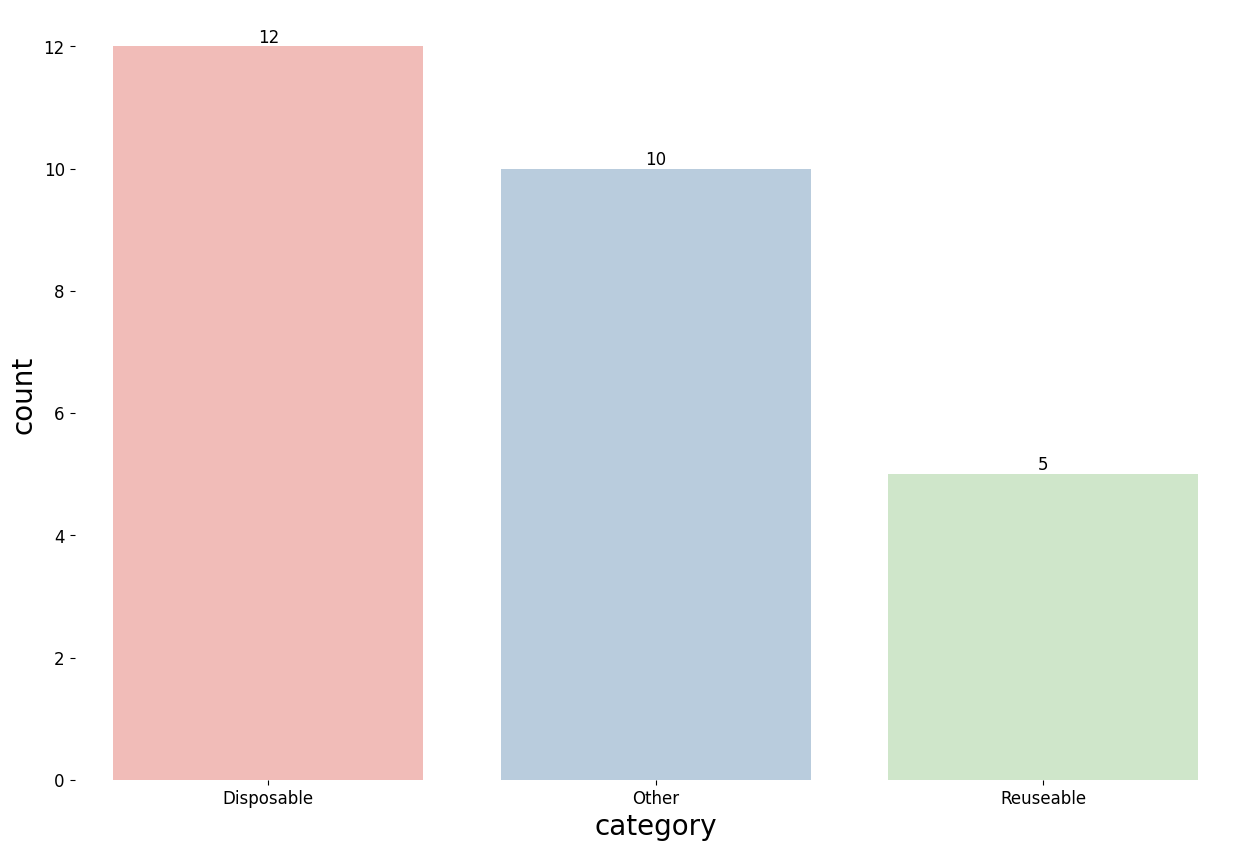

In [17]:
# Classifying masks to different categories
products['category'] = products['product_name'].apply(defineCategory)



plt.figure(figsize=(15,10))
ax = sns.countplot(x='category', data=products, palette='Pastel1')
ax.bar_label(ax.containers[0], fontsize=12)

ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

ax.tick_params(axis='both', which='major', labelsize=12)

sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

#### Rating Distribution

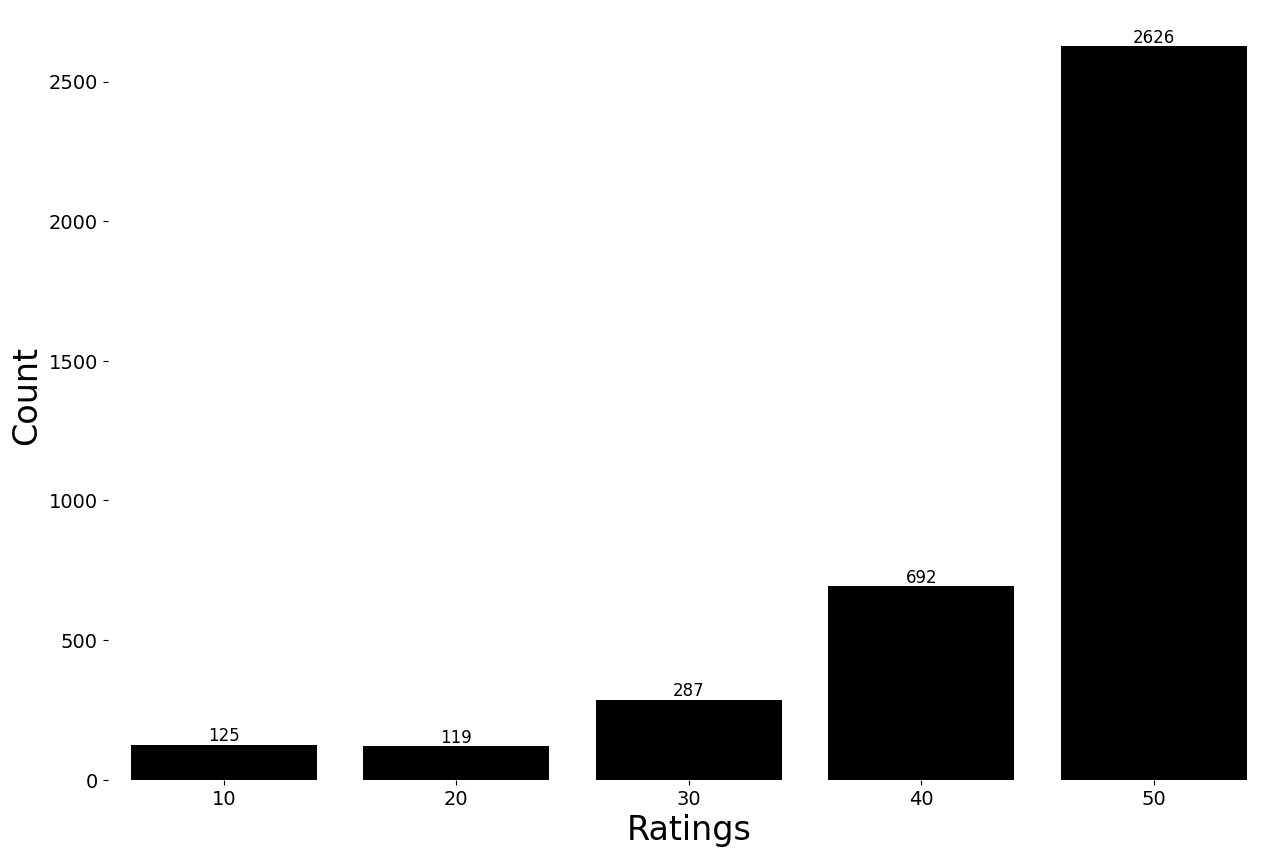

In [18]:
plt.figure(figsize=(15,10))
ax = sns.countplot(x='ratingValue', data=df, color='k')
ax.bar_label(ax.containers[0], fontsize=12)

ax.set_xlabel("Ratings")
ax.set_ylabel("Count")

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)


ax.tick_params(axis='both', which='major', labelsize=14)

sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()


#### Ratings Distribution based on Categories

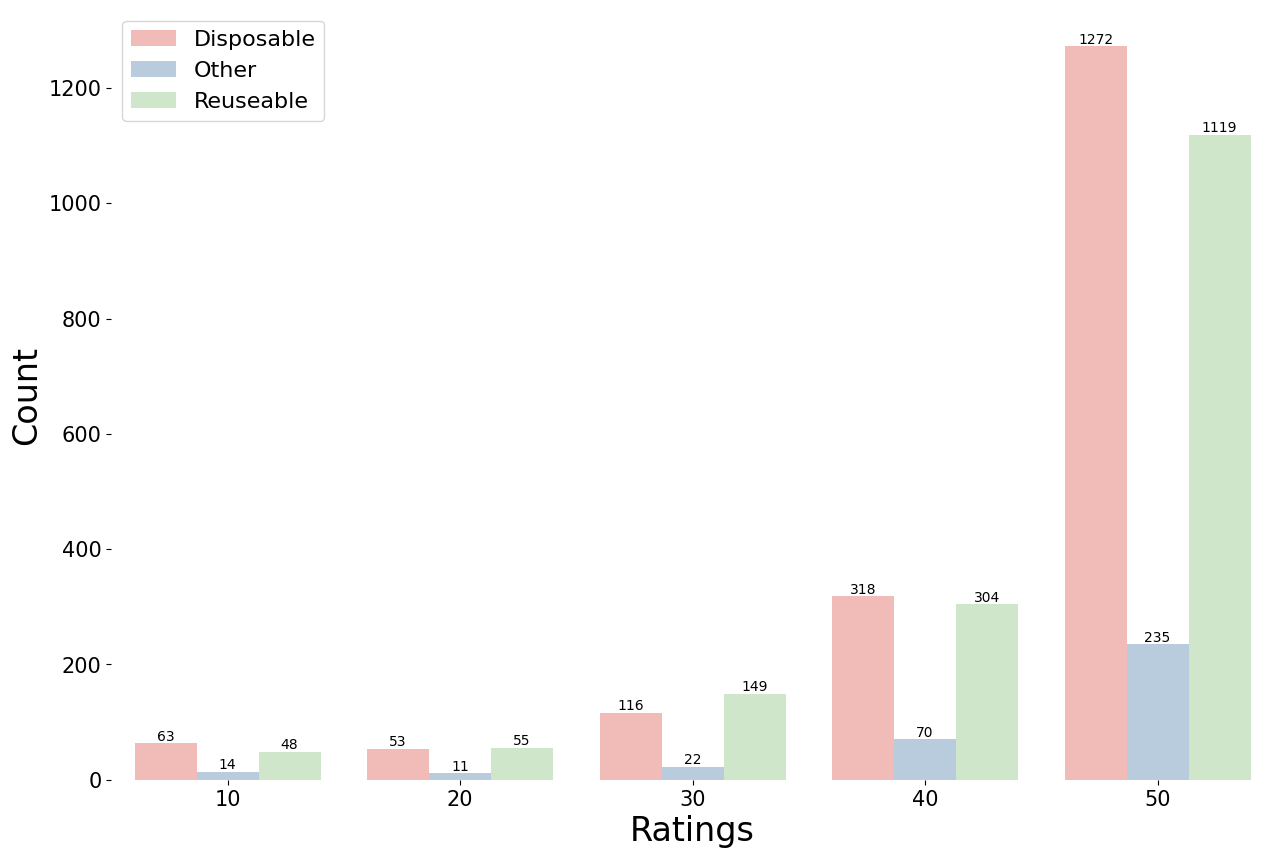

In [19]:
plt.figure(figsize=(15,10))

ax = sns.countplot(x='ratingValue', hue='category', data=df, palette='Pastel1')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.bar_label(ax.containers[2])

ax.set_xlabel("Ratings")
ax.set_ylabel("Count")

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)

ax.legend(fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=15)

sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

#### Average Rating for each Product

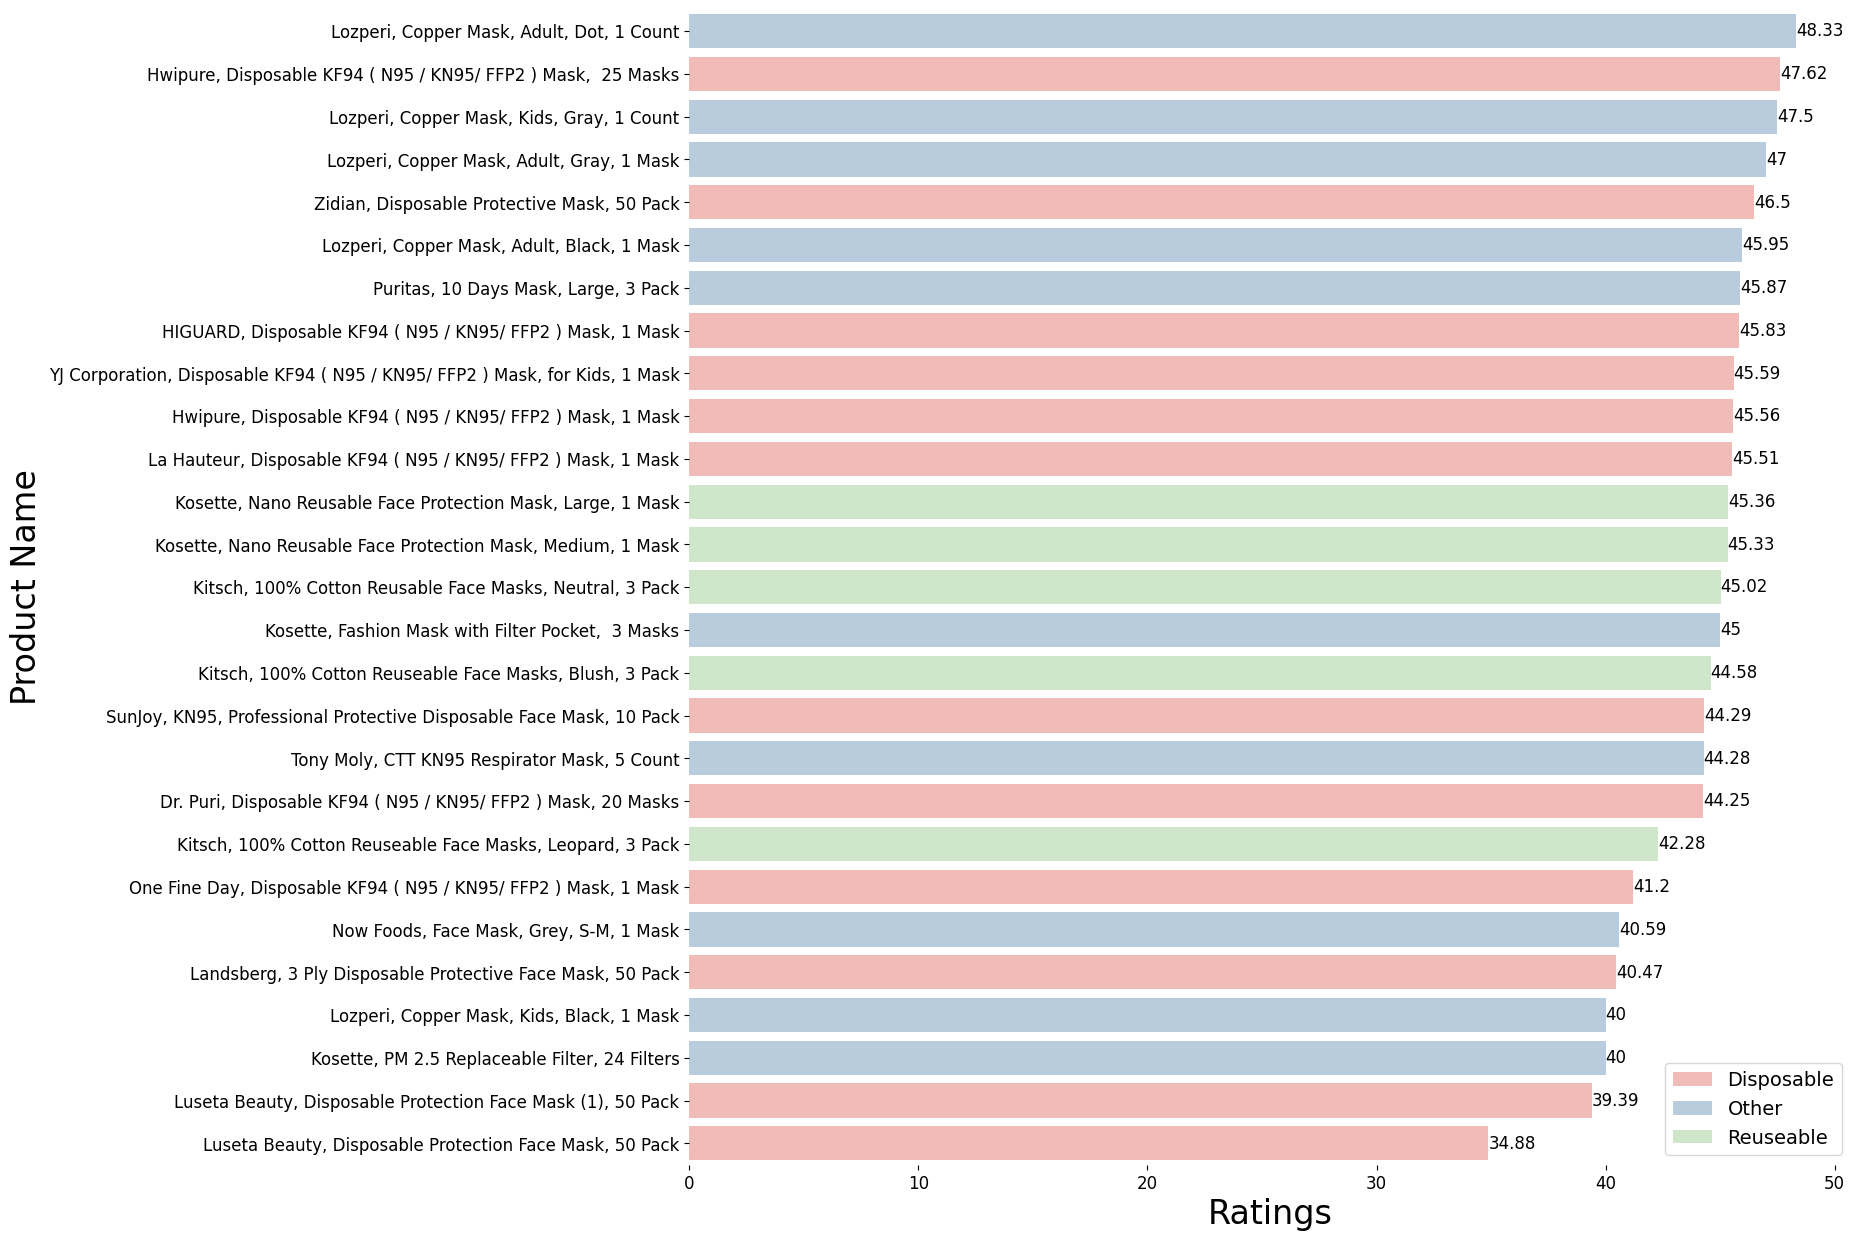

In [20]:
plt.figure(figsize=(15,15))

order = products.sort_values('ratingValue', ascending=False).product_name
# products_names = [' '.join(i.split()[:5]) for i in order]

ax = sns.barplot(data=products, x='ratingValue', y='product_name', 
                order= order,
                hue='category', palette='Pastel1', dodge=False)

for i in range(3):
    ax.bar_label(ax.containers[i], fontsize=12)

# ax.set_yticklabels(products_names)

ax.set_xlabel("Ratings")
ax.set_ylabel("Product Name")

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)

ax.legend(fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

#### Cost(per mask) for each Product 

Order of Products is based on above graph order, HIghest Rated Product to Least Rated Product

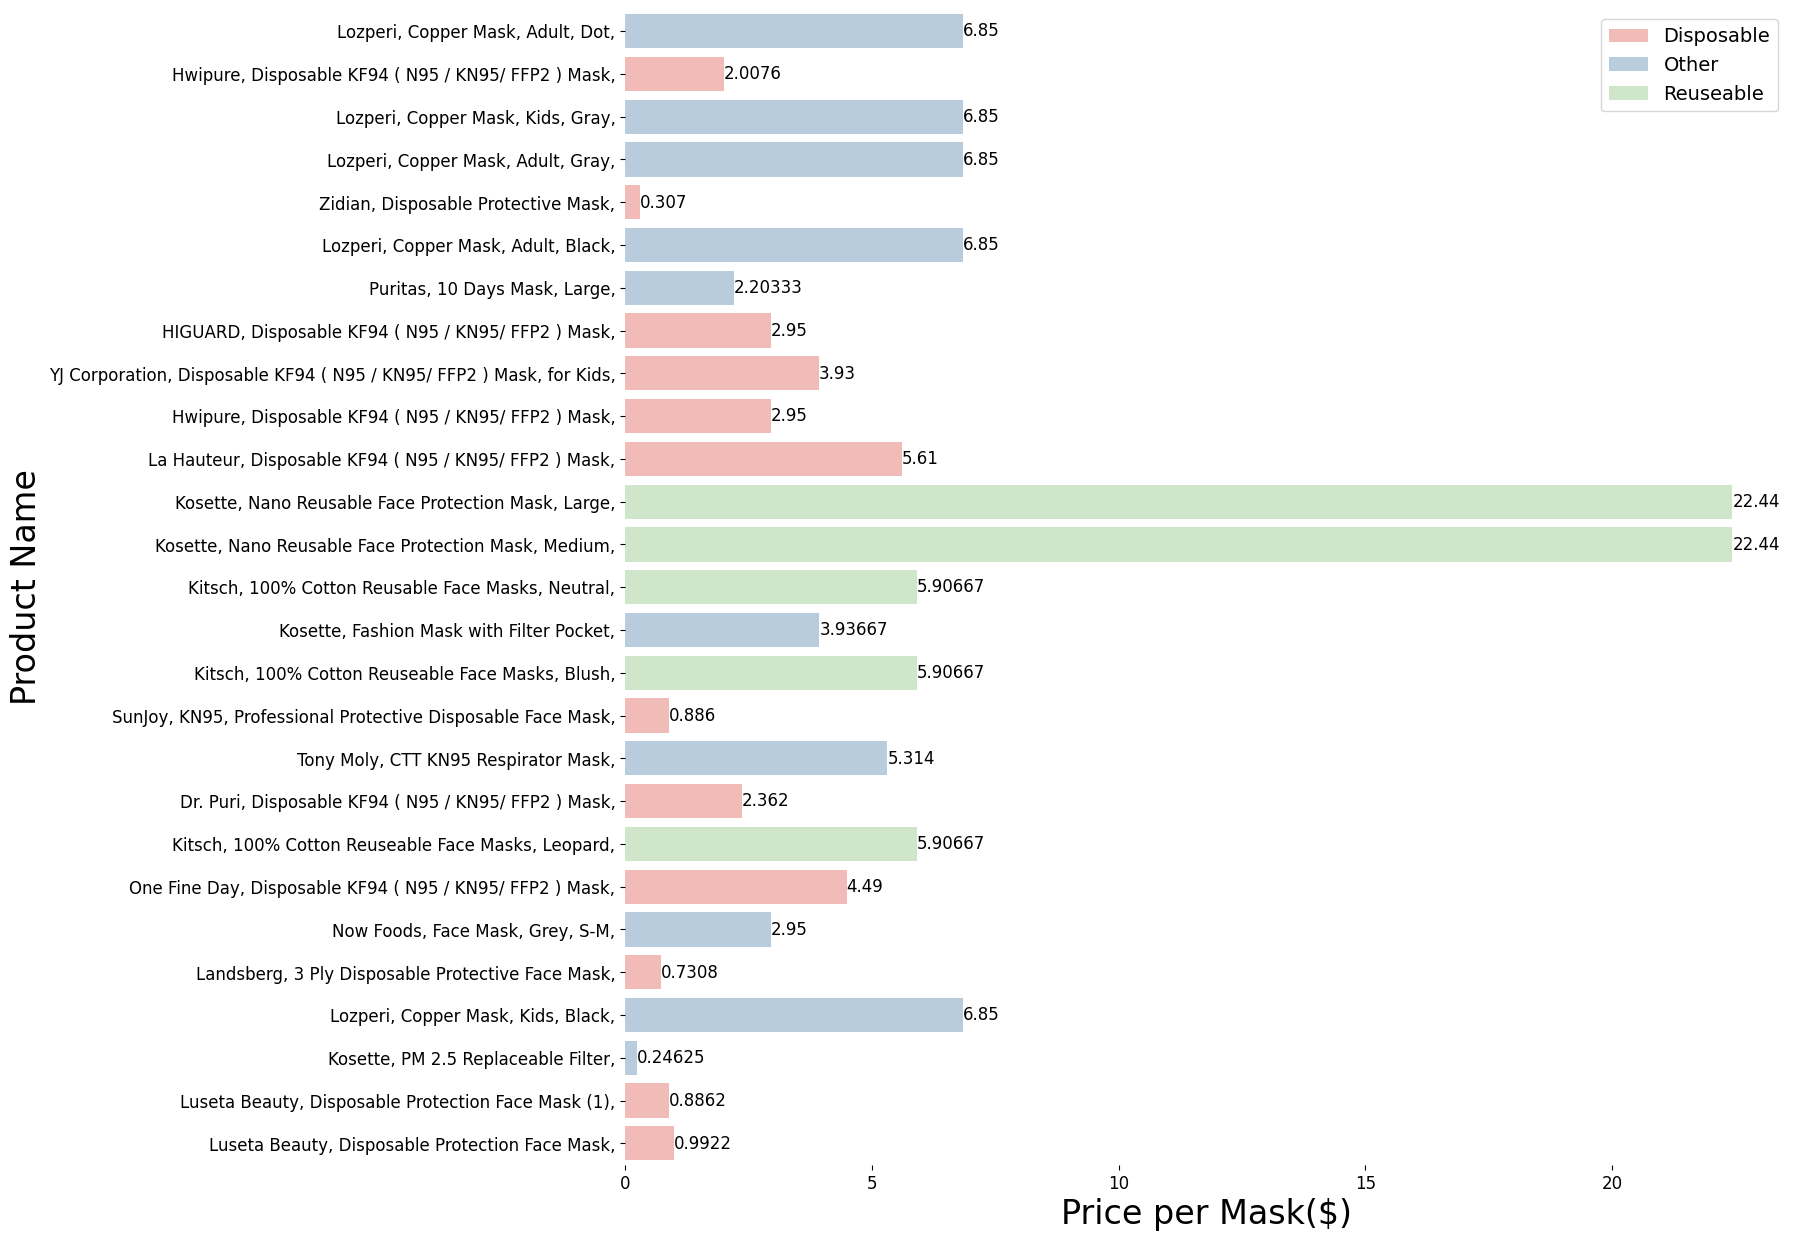

In [21]:
plt.figure(figsize=(15,15))

order = products.sort_values('ratingValue', ascending=False).product_name
products_names = [' '.join(i.split()[:-2]) for i in order]

ax = sns.barplot(data=products, x='price_mask', y='product_name', 
                order= order,
                hue='category', palette='Pastel1', dodge=False)

for i in range(3):
    ax.bar_label(ax.containers[i], fontsize=12)

ax.set_yticklabels(products_names)

ax.set_xlabel("Price per Mask($)")
ax.set_ylabel("Product Name")

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)


ax.legend(fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

There seems to be no proper relation between better product and the price per each mask.

#### Helpfulness of Reviews for each graph
Order of Products is based on above graph order, HIghest Rated Product to Least Rated Product

In [22]:
ax.containers[0]

<BarContainer object of 27 artists>

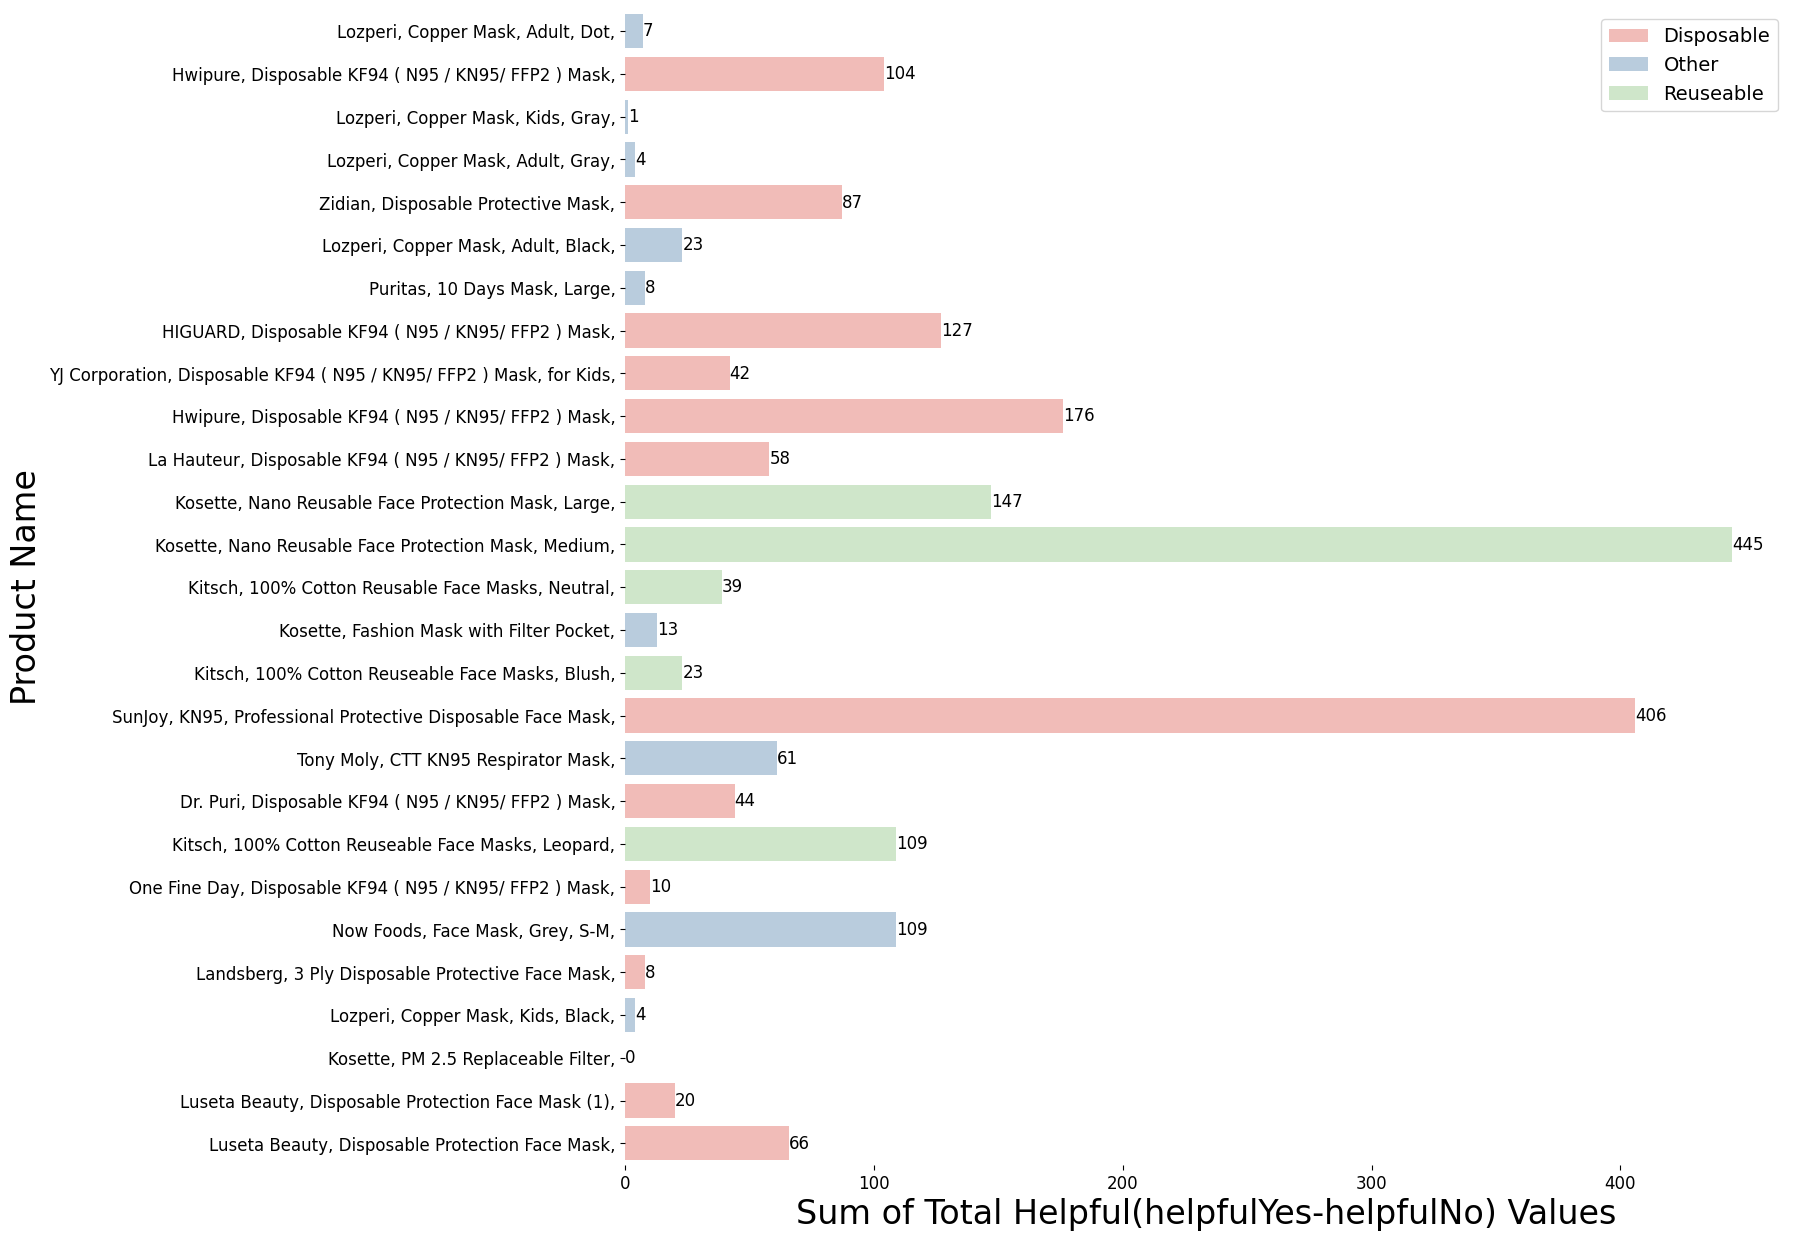

In [23]:
plt.figure(figsize=(15,15))

order = products.sort_values('ratingValue', ascending=False).product_name
products_names = [' '.join(i.split()[:-2]) for i in order]

ax = sns.barplot(data=products, x='helpful', y='product_name', 
                order= order,
                hue='category', palette='Pastel1', dodge=False)

for i in range(3):
    ax.bar_label(ax.containers[i], fontsize=12)

ax.set_yticklabels(products_names)

ax.set_xlabel("Sum of Total Helpful(helpfulYes-helpfulNo) Values")
ax.set_ylabel("Product Name")

ax.xaxis.label.set_size(24)
ax.yaxis.label.set_size(24)


ax.legend(fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=12)

sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.show()

The products which are not so famous have reviews which were helpful to other people

##  Which are the most popular face masks out there?

### Top 3 Products Overall

* Lozperi, Copper Mask, Adult, Dot, 1 Count 
* Hwipure, Disposable KF94 ( N95 / KN95/ FFP2 ) Mask,  25 Masks
* Lozperi, Copper Mask, Kids, Gray, 1 Count

### Top Product in each Category

* **Others** - Lozperi, Copper Mask, Adult, Dot, 1 Count 
* **Disposable** - Hwipure, Disposable KF94 ( N95 / KN95/ FFP2 ) Mask,  25 Masks
* **Reusable** - Kosette, Nano Reusable Face Protection Mask, Medium, 1 Mask

## What do consumers like about them? Why?

In [24]:
def getFreqDict(df: pd.DataFrame) -> dict:
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(set(['masks', 'mask', 'face']))

    d = Counter()
    for rev in df.review:
            
            # Removing punctions from string
            rev = rev.translate(str.maketrans('', '', string.punctuation))
            
            # Removing stop words
            word_tokens = word_tokenize(rev)
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
            
            d.update(filtered_sentence)
    
    return d

In [25]:
def makeImage(freq_dict: dict) -> None:
    """
    Generate Word Cloud of the given frequency dictionary
    """
    wc = WordCloud(width=1200, height=1200, background_color="white", max_words=20)
    # generate word cloud
    wc.generate_from_frequencies(freq_dict)

    # show
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [26]:
df_good = df[df.ratingValue>30]
df_bad = df[df.ratingValue<30]

### Good Rating Word Cloud

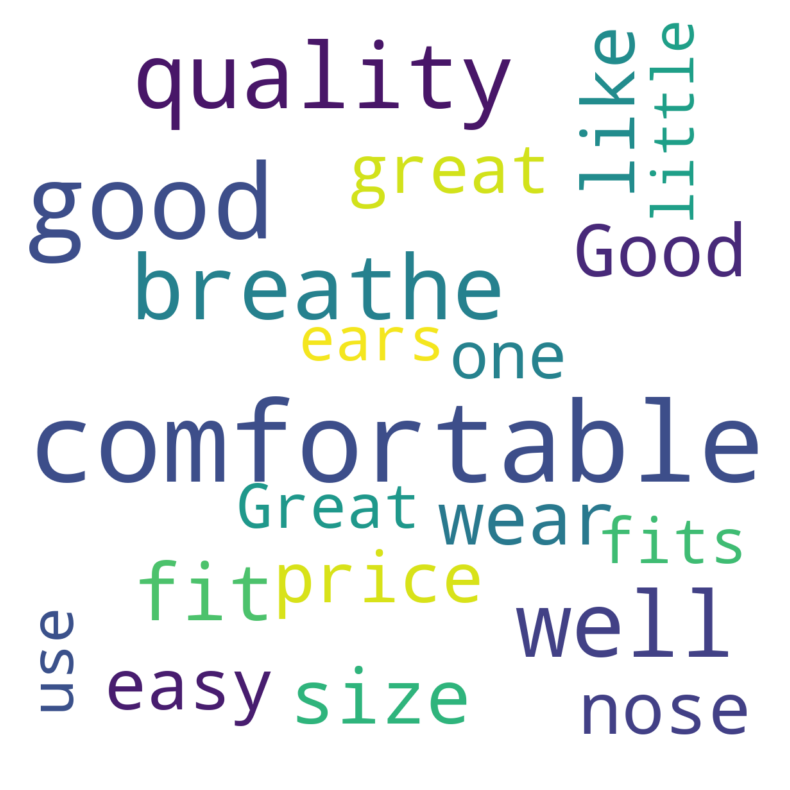

In [27]:
freq_dict = getFreqDict(df_good)
makeImage(freq_dict)

### Bad Rating Word Cloud

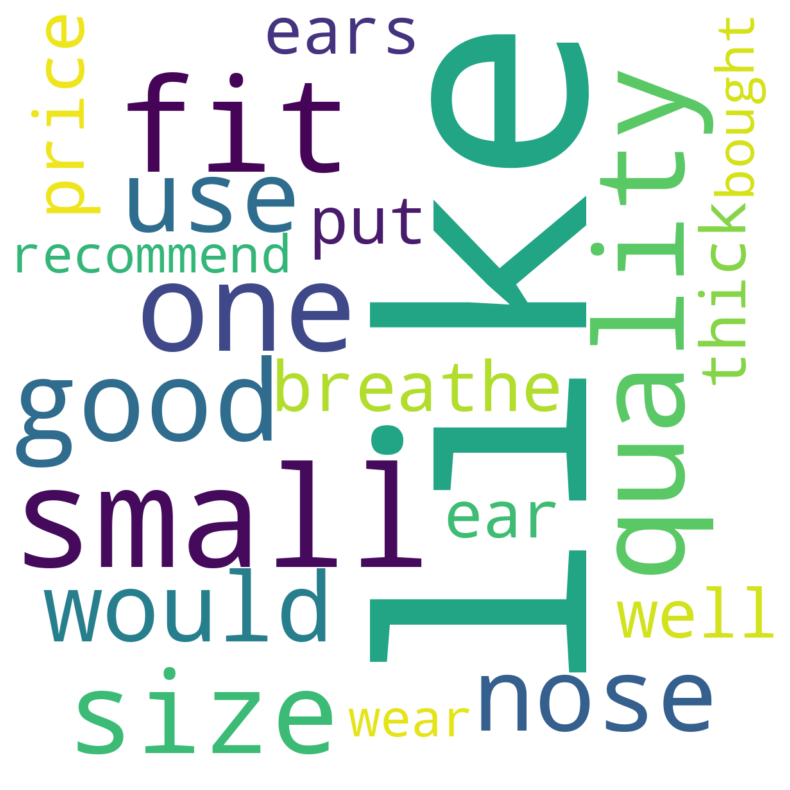

In [28]:
freq_dict = getFreqDict(df_bad)
makeImage(freq_dict)

Since it's only one word, some words which may be positive are in bad reviews, like good (where as in negative it may be not good)

### BiGram Word Cloud

#### World Cloud for Good Ratings with BiGrams

In [29]:
def getFreqDict(df: pd.DataFrame) -> dict:
    stop_words = set(stopwords.words('english'))
    stop_words = stop_words.union(set(['masks', 'mask', 'face']))

    d = Counter()
    for rev in df.review:
            
            # Removing punctions from string
            rev = rev.translate(str.maketrans('', '', string.punctuation))
            
            # Removing stop words
            word_tokens = word_tokenize(rev)
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
            bigram_seq = []
            for i in range(len(filtered_sentence)-1):
                bigram_seq.append(filtered_sentence[i]+" "+filtered_sentence[i+1])
            
            d.update(bigram_seq)
    
    return d

#### World Cloud for Bad Ratings with BiGrams

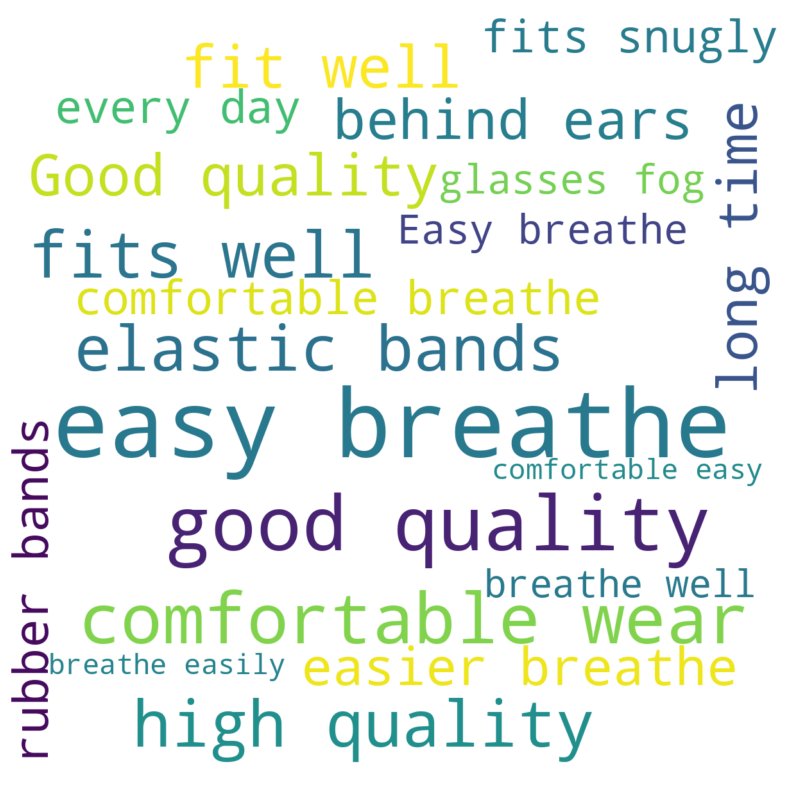

In [30]:
freq_dict = getFreqDict(df_good)
makeImage(freq_dict)

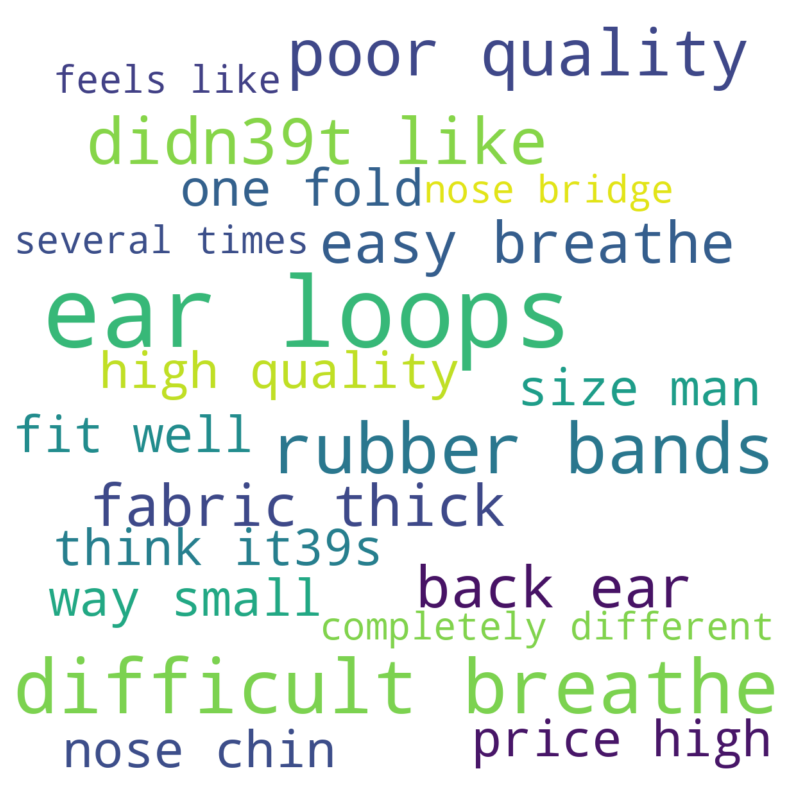

In [31]:
freq_dict = getFreqDict(df_bad)
makeImage(freq_dict)

In BiGrams it's more easy to see, which words are occuring more in Negative reviews and depicts negative sentiment

## What different profiles of consumers buy masks? 

### Customer Profile based on Language Code

In [32]:
lang = set()
country = set()
lang_iso = {'BR':"BRA", 'CN':"CHN", 'DE':"DEU", 'FR':"FRA", 'IL':"ISR", 'JP':"JPN", 'KR':"KOR", 'MX':"MEX", 
            'RU':"RUS", 'SA':"SAU", 'TW':"TWN", 'US':"USA"}
for i in df.languageCode.unique():
    l,c = i.split("-")
    lang.add(l)
    country.add(lang_iso[c])

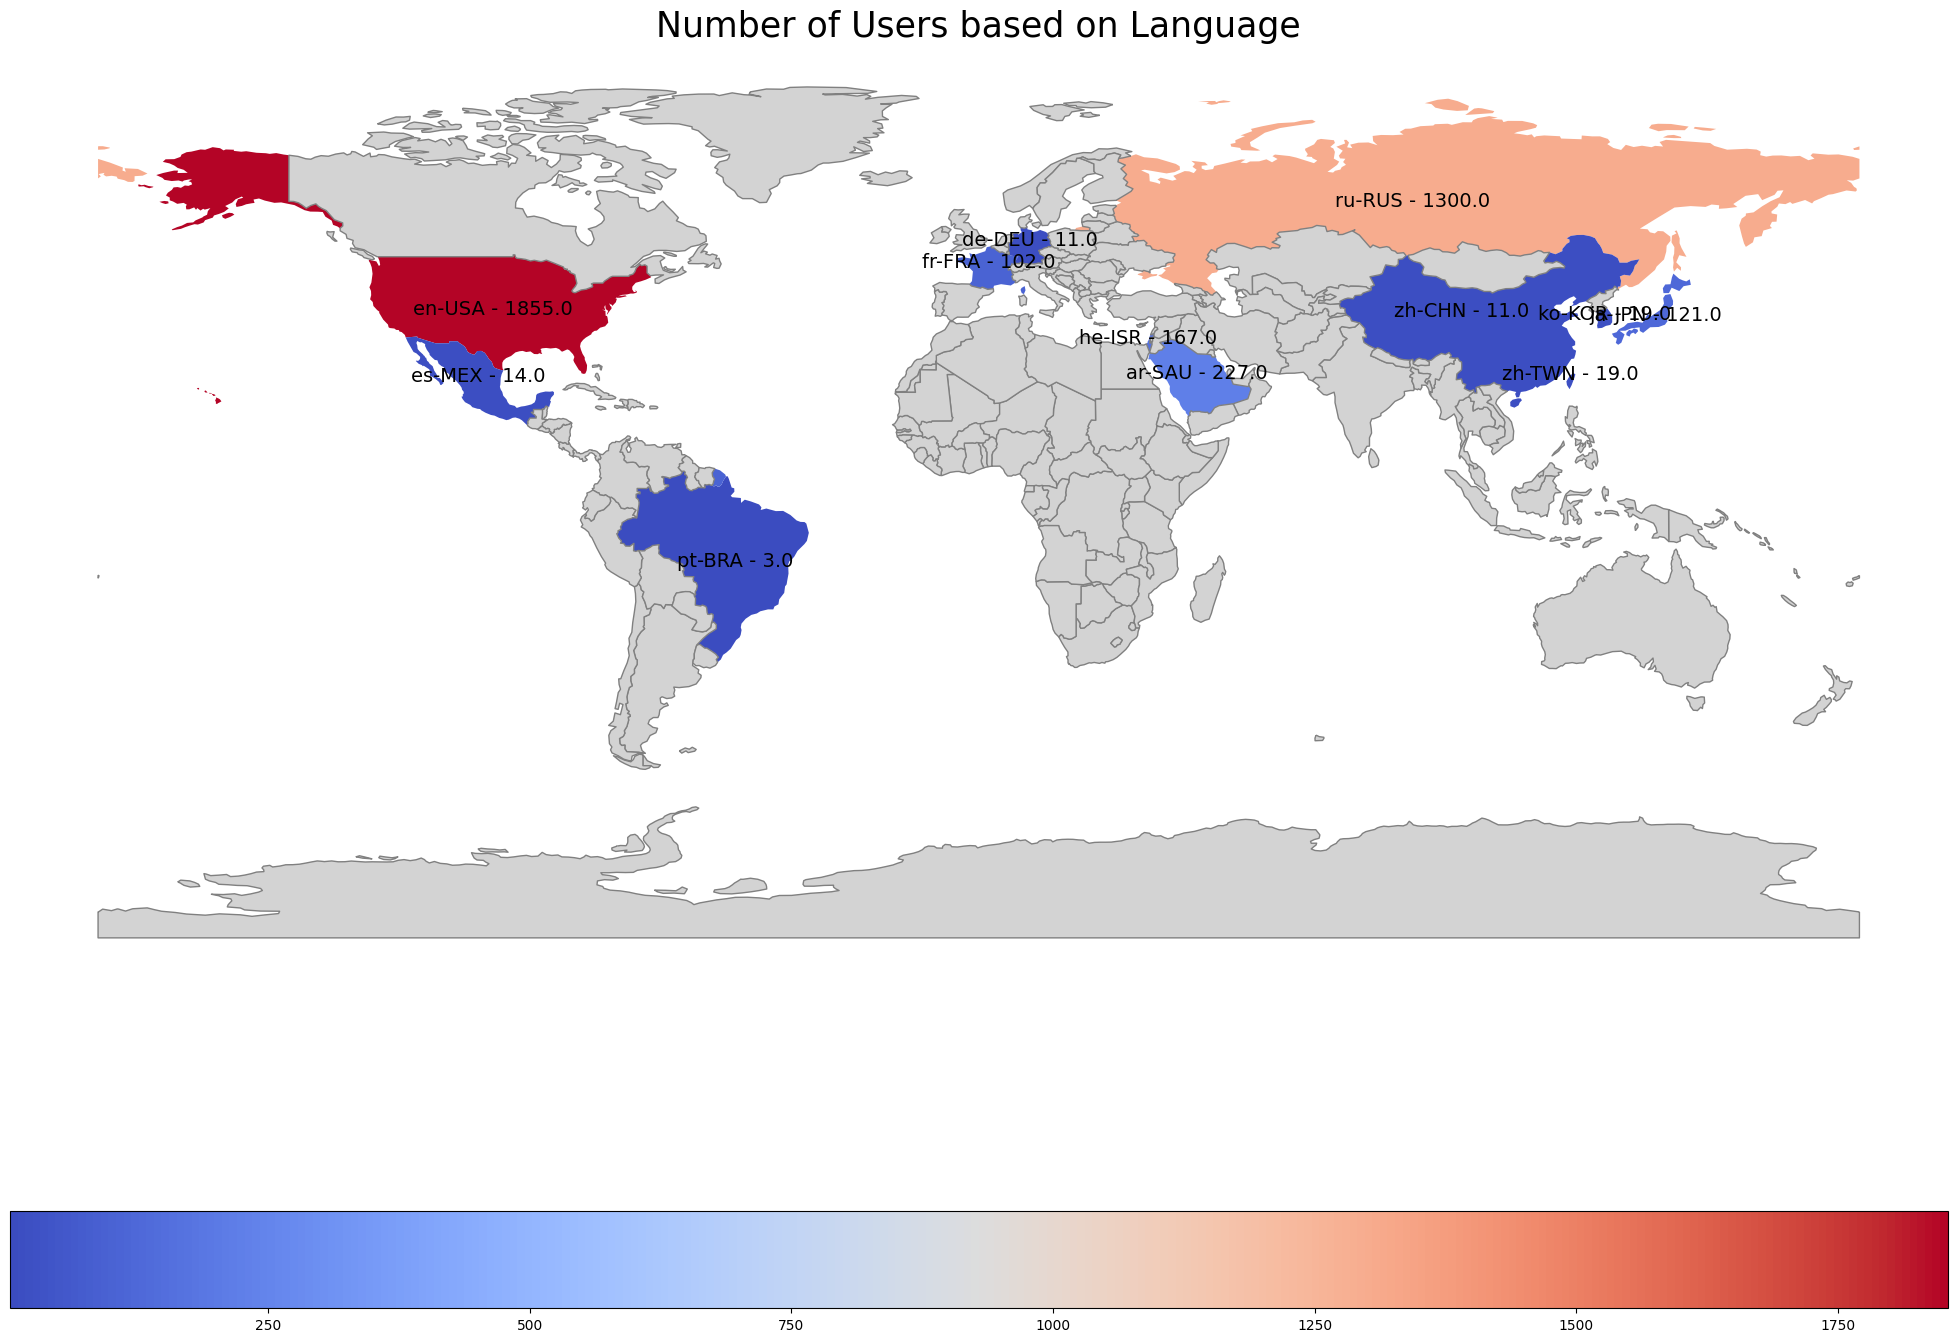

In [33]:
result = df.groupby(['languageCode']).agg({'review': 'count'})
result.reset_index(inplace=True)
result[['lang','country']] = result['languageCode'].str.split('-',expand=True)
result['country'] = result['country'].map(lang_iso)
result.drop(['languageCode'], inplace=True, axis=1)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.merge(result, how='left', left_on="iso_a3", right_on="country" )
# world.review.fillna(0, inplace=True)
world['coords'] = world['geometry'].apply(lambda x: x.representative_point().coords[:])
world['coords'] = [coords[0] for coords in world['coords']]


# plot confirmed cases world map 
ax = world.plot(column='review', #scheme="quantiles",
           figsize=(25, 20),
           legend=True,
           cmap='coolwarm',
           missing_kwds={
        "color": "lightgrey",
        "edgecolor": "grey",
        # "hatch": "///",
        "label": "Missing values",
        },
           legend_kwds={'orientation': "horizontal"})


ax.set_axis_off()

plt.title('Number of Users based on Language',fontsize=25)

for idx, row in world.iterrows():
   if not pd.isna(row.review):
      text = f"{row.lang}-{row.country} - {row.review}" 
      plt.annotate(text=text, xy=row['coords'],
                 horizontalalignment='center',
                 fontsize=14)
                
plt.show()